# Quantifying political influence on COVID-19 fatality in Brazil
Plotting and analysis rouine for COVID19 vs outcome of 2018 Brazil elections.

Authors: Leandro de Almeida, Pedro Carelli, Daniel Felinto and José Dias do Nascimento Jr
Code: Almeida, L

### Data Source
#### 2018 Elections

THe data was retrieved from TSE using the website "Gazeta do Povo" and compiled at:
https://especiais.gazetadopovo.com.br/eleicoes/2018/resultados/mapa-eleitoral-de-presidente-por-municipios-2turno/

#### COVID19 Deaths confirmed by state
All cases reported here were confirmed by the health departments of each state, and also obtained by the official platform of the Ministry of Health. The consulted sources are listed at the bottom of the page. All data is available in CSV format on Github: https://github.com/wcota/covid19br
W. Cota, “Monitoring the number of COVID-19 cases and deaths in brazil at municipal and federative units level”, SciELOPreprints:362 (2020), 10.1590/scielopreprints.362

The fatality data and votes was related in this routine.

# #

## First, some lines to define the style

In [6]:
#IAll Libraries needed here
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.stats import pearsonr
%matplotlib inline

def estilo():
    from matplotlib import rcParams
    import matplotlib.font_manager as font_manager
    rcParams['font.family'] = 'Times New Roman'
    rcParams['mathtext.fontset'] = 'dejavuserif'
    rcParams['axes.linewidth'] = 1.2
estilo()  

def sm_ted2():
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",top = False,right = True, length=5,width=1,labelsize=15)
    plt.tick_params(axis='both',which='major', direction = "in",top = False,right = True, length=8,width=1,labelsize=15)

## Now we import our data

In [2]:
#Election data
eleicoes = pd.read_excel('2018_eleicoes.xlsx')
eleicoes = eleicoes[eleicoes['nacionalidade'] == 'Brasil']
#COVID19 data
covid = pd.read_csv('covid_freeze_data_brazil.csv',sep=',')
#Population data
pop = pd.read_csv('Siglas.csv')

c:\users\monol\appdata\local\programs\python\python37\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Just run a test at specific date

Here we select the a specific date to test out the convergence of the code, by choosing the legends for Bolsonaro (at the time) and Haddad, 17 and 13 respectively

In [14]:
legend1 = 17
legend2 = 13
# here we set how many days back ([-1] is the last day (17-11-2021))
daysback = 1

estado = []
populacao = []
pt1 = []
psl1 = []
pt2 = []
psl2 = []
obitos = []
estados = []

data = np.array(covid['date'][covid['state'] == 'AC'])[-daysback] 
print('Total de estados: ', len(pop))
for i in range(len(pop)):
    uf = pop['sigla'][i]
    Estado = pop['Sigla'][i]
    print(i,end='\r')
    pt2 = np.append(pt2,np.sum(eleicoes['totalVotos'][(eleicoes['uf'] == uf) & (eleicoes['numeroCandidato'] == legend2) & (eleicoes['turno']==2)]))
    psl2 = np.append(psl2,np.sum(eleicoes['totalVotos'][(eleicoes['uf'] == uf) & (eleicoes['numeroCandidato'] == legend1) & (eleicoes['turno']==2)]))
    obitos = np.append(obitos,covid['deaths_per_100k_inhabitants'][(covid['date']==data) & (covid['state'] == Estado)])
    estados = np.append(estados,pop['Sigla'][i])

Total de estados:  27


## Here we compute the voting rate in each Candidate by state and region

Also we set a linear function to be fitted to each day of the sample to plot visualy the trend

In [15]:
Y = obitos*10
XPT = 100*pt2/(pt2+psl2)
XPSL= 100*psl2/(pt2+psl2)

XPT = XPT[Y>0]
XPSL = XPSL[Y>0]
estadoS = estados[Y>0]
Y = Y[Y > 0]


mask = XPT > 0

XPT=XPT[mask]
XPSL=XPSL[mask]
Y=Y[mask]
estadoS=estadoS[mask]

#Define a function to fit linear dispersion
def func(tempo, A, B):
    valor = A*tempo + B
    return valor

paramsPSL, params_covariancePSL = optimize.curve_fit(func, XPSL, Y, p0=[1, 1])
paramsPT, params_covariancePT = optimize.curve_fit(func, XPT, Y, p0=[1, 1])
print(paramsPSL)
print(paramsPT)
x = np.linspace(0,100,10)
funcaoPSL = func(x, paramsPSL[0], paramsPSL[1])
errosPSL = np.sqrt(np.diag(params_covariancePSL))
funcaoPT = func(x, paramsPT[0], paramsPT[1])
errosPT = np.sqrt(np.diag(params_covariancePT))

cores = []
CORES = []
regiao = []
for i in range(len(estadoS)):
    ES = estadoS[i]
    if ES == 'PI' or ES == 'PE' or ES == 'CE' or ES == 'BA' or ES == 'MA' or ES == 'RN' or ES == 'AL' or ES == 'PB' or ES == 'SE': 
        CORES = np.append(CORES,'red')
        regiao = np.append(regiao,'nordeste')
    if ES == 'RJ' or ES == 'SP' or ES == 'ES' or ES == 'MG':  
        CORES = np.append(CORES,'orange')
        regiao = np.append(regiao,'suldeste')
    if ES == 'RS' or ES == 'SC' or ES == 'PR':  
        CORES = np.append(CORES,'blue')
        regiao = np.append(regiao,'sul')
    if ES == 'MG' or ES == 'MS' or ES == 'GO':  
        CORES = np.append(CORES,'brown')
        regiao = np.append(regiao,'centro-oeste')
    if ES == 'AM' or ES == 'AC' or ES == 'PA' or ES == 'RO' or ES == 'RR' or ES == 'AP' or ES == 'TO':  
        CORES = np.append(CORES,'green')
        regiao = np.append(regiao,'norte')
    if ES == 'DF':  
        CORES = np.append(CORES,'magenta')
        regiao = np.append(regiao,'DF')

[  29.8982932  1225.44088759]
[ -29.89829313 4215.2702046 ]


# Pearson Correlation Coefficient
The Pearson correlation coefficient is named for Karl Pearson and gives us the strength of the linear relationship between two data samples.

The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score.

$$R_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

where $cov(X,Y)$ is the covariance between X and Y:

$$cov(X,Y) = \sum_{i=1}^{n} (X_i-\bar{X})(Y_i-\bar{Y})$$

As the standard variantion is simply the variance squared, the Pearson Correlation Coefficient is then:

$$R_{X,Y} = \frac{\sum_{i=1}^{n} (X_i-\bar{X})(Y_i-\bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i-\bar{X})^2}\sqrt{\sum_{i=1}^{n} (Y_i-\bar{Y})^2}}   $$

where n is the sample size, $X_i$ and $Y_i$ are the individual sample points and $\bar{X}$ and $\bar{Y}$ are the mean of sample X and Y.

The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values below those values suggests a less notable correlation.

To get the Pearson correlation coefficient for our data, we tested the SciPy function scipy.stats.pearsonr, wich gives us the correct value for each date, and also the np.corrcoef from numpy wich gives the same result.

## Test at last date

0.7203618925325458 0.7203618925325459


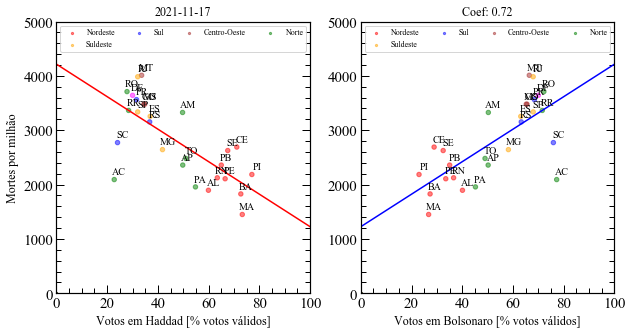

In [16]:
fig = plt.subplots(figsize=[10, 5])
ax1 = plt.subplot(121)
plt.title(data)


plt.scatter(XPT,Y,c=CORES,s=20,alpha=0.5)
for i in range(len(XPT)):
    #plt.plot(XPT[i],Y[i],".")
    plt.annotate(estadoS[i],(XPT[i],Y[i]),textcoords="offset points",xytext=(5,5),ha='center',color='k',size=10) 
plt.plot(x,funcaoPT,'r-') 
plt.xlabel('Votos em Haddad [% votos válidos]',{'fontsize':12})
plt.ylabel('Mortes por milhão',{'fontsize':12})
plt.xlim(0,100)
plt.ylim(0,5000)
plt.scatter(0,0,c='red',s=5,alpha=0.5,label='Nordeste')
plt.scatter(0,0,c='orange',s=5,alpha=0.5,label='Suldeste')
plt.scatter(0,0,c='blue',s=5,alpha=0.5,label='Sul')
plt.scatter(0,0,c='brown',s=5,alpha=0.5,label='Centro-Oeste')
plt.scatter(0,0,c='green',s=5,alpha=0.5,label='Norte')
plt.legend(loc=1,fontsize=8,mode = "expand", ncol = 4)
sm_ted2()

valor0 = pearsonr(XPSL,Y)
valor = np.corrcoef([XPSL,Y])

print(valor0[0],valor[0,1])

ax2 = plt.subplot(122)
plt.title('Coef: '+str(np.round(valor[0,1],2)))
plt.scatter(XPSL,Y,c=CORES,s=20,alpha=0.5)
for i in range(len(XPSL)):
    #plt.plot(XPSL[i],Y[i],".")
    plt.annotate(estadoS[i],(XPSL[i],Y[i]),textcoords="offset points",xytext=(5,5),ha='center',color='k',size=10) 
plt.plot(x,funcaoPSL,'b-')   
plt.xlabel('Votos em Bolsonaro [% votos válidos]',{'fontsize':12})
plt.xlim(0,100)
plt.ylim(0,5000)
plt.scatter(0,0,c='red',s=5,alpha=0.5,label='Nordeste')
plt.scatter(0,0,c='orange',s=5,alpha=0.5,label='Suldeste')
plt.scatter(0,0,c='blue',s=5,alpha=0.5,label='Sul')
plt.scatter(0,0,c='brown',s=5,alpha=0.5,label='Centro-Oeste')
plt.scatter(0,0,c='green',s=5,alpha=0.5,label='Norte')
plt.legend(loc=1,fontsize=8,mode = "expand", ncol = 4)
sm_ted2()
plt.savefig('Diagrama_Obitos_Votos_2.png',dpi=250)

In [17]:
print('How many days of pandemic: ',len(np.array(covid['date'][covid['state'] == 'AC'])))

How many days of pandemic:  611


# Paper Figure 1

Total de estados:  27
Total de estados:  27
Total de estados:  27
Total de estados:  27
Total de estados:  27


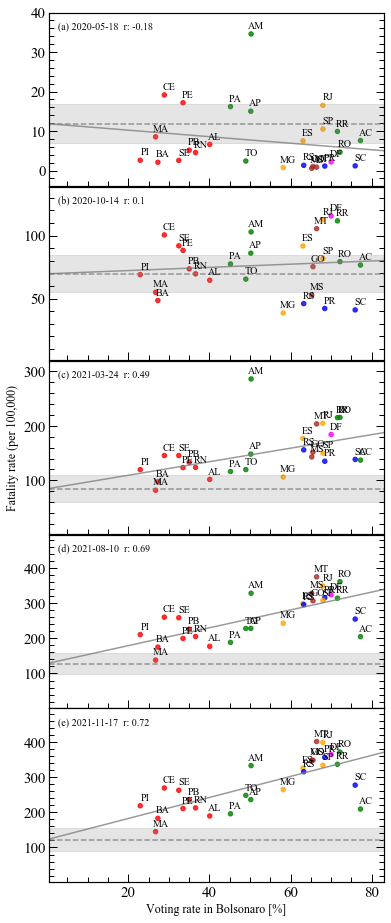

In [18]:
pratras = 1
quandos = [-549,-400,-239,-100,-1]
limites = [40,139,320,495,495]
limites0 =[-4,1,1,1,1]
letra = ['(a)','(b)','(c)','(d)','(e)']


fig = plt.subplots(figsize=[6, 16])
for i in range(len(quandos)):

    qual = i

    estado = []
    populacao = []
    pt1 = []
    psl1 = []
    pt2 = []
    psl2 = []
    obitos = []
    estados = []

    data = np.array(covid['date'][covid['state'] == 'AC'])[quandos[qual]] # Aqui diz quantos dias pra tras vai ser ([-1] é até o último dia)
    print('Total de estados: ', len(pop))
    for i in range(len(pop)):
        uf = pop['sigla'][i]
        Estado = pop['Sigla'][i]
        print(i,end='\r')
        pt2 = np.append(pt2,np.sum(eleicoes['totalVotos'][(eleicoes['uf'] == uf) & (eleicoes['numeroCandidato'] == 13) & (eleicoes['turno']==2)]))
        psl2 = np.append(psl2,np.sum(eleicoes['totalVotos'][(eleicoes['uf'] == uf) & (eleicoes['numeroCandidato'] == 17) & (eleicoes['turno']==2)]))
        obitos = np.append(obitos,covid['deaths_per_100k_inhabitants'][(covid['date']==data) & (covid['state'] == Estado)])
        estados = np.append(estados,pop['Sigla'][i])

    Y = obitos
    XPT = 100*pt2/(pt2+psl2)
    XPSL= 100*psl2/(pt2+psl2)

    XPT = XPT[Y>0]
    XPSL = XPSL[Y>0]
    estadoS = estados[Y>0]
    Y = Y[Y > 0]
    mask = XPT > 0

    XPT=XPT[mask]
    XPSL=XPSL[mask]
    Y=Y[mask]
    estadoS=estadoS[mask]

    paramsPSL, params_covariancePSL = optimize.curve_fit(func, XPSL, Y, p0=[1, 1])

    x = np.linspace(0,100,10)
    funcaoPSL = func(x, paramsPSL[0], paramsPSL[1])
    errosPSL = np.sqrt(np.diag(params_covariancePSL))

    valor = np.corrcoef([XPSL,Y])
    ax1 = plt.subplot(5,1,qual+1)
    
    
    #plt.title(letra[qual]+'   '+data+'    '+'Coef: '+str(np.round(valor[0,1],2)),loc='left')
    plt.scatter(XPSL,Y,c=CORES,s=20,alpha=0.8) # se quiser as cores dos estados, colocar c = CORES
    for i in range(len(XPSL)):
        #plt.plot(XPSL[i],Y[i],".")
        plt.annotate(estadoS[i],(XPSL[i],Y[i]),textcoords="offset points",xytext=(5,5),ha='center',color='k',size=10) 
    plt.plot(x,funcaoPSL,'-',color='gray',alpha=0.8)
    plt.axhline(y=funcaoPSL[0],color='gray',linestyle='--',alpha=0.8)
    plt.fill_between(x,y1=funcaoPSL[0]-errosPSL[1],y2=funcaoPSL[0]+errosPSL[1],color='gray',alpha=0.2)
    
    if qual == 4:
        plt.xlabel('Voting rate in Bolsonaro [%]',{'fontsize':12})
    if qual == 2:
        plt.ylabel('Fatality rate (per 100,000)',{'fontsize':12})

    plt.xlim(0.5,83)
    plt.ylim(limites0[qual],limites[qual])
    
    #plt.scatter(0,0,c='red',s=5,alpha=0.5,label='Nordeste')
    #plt.scatter(0,0,c='orange',s=5,alpha=0.5,label='Suldeste')
    #plt.scatter(0,0,c='blue',s=5,alpha=0.5,label='Sul')
    #plt.scatter(0,0,c='brown',s=5,alpha=0.5,label='Centro-Oeste')
    #plt.scatter(0,0,c='green',s=5,alpha=0.5,label='Norte')
    plt.scatter(0,0,c='green',s=5,alpha=0.5,label=letra[qual]+' '+data+'  '+'r: '+str(np.round(valor[0,1],2)))
    leg = plt.legend(handlelength=0, handletextpad=0, frameon=False,loc=2)
    for item in leg.legendHandles:
        item.set_visible(False)
    plt.subplots_adjust(hspace = .001)
    sm_ted2()
    
#plt.tight_layout()
plt.savefig('FIGURES/FIGURE1.png',dpi=500)


## Here we compute the Pearson CC over all data

In [19]:
pearson = []
DATA = []
EXC = []
EXCerr = []
OBM = []

for s in range(len(covid[covid['state'] == 'AC'])):
    data = np.array(covid['date'][covid['state'] == 'AC'])[s]
    try:
        pt1 = []
        psl1 = []
        pt2 = []
        psl2 = []
        obitos = []
        for i in range(len(pop)):
            uf = pop['sigla'][i]
            Estado = pop['Sigla'][i]
            pt2 = np.append(pt2,np.sum(eleicoes['totalVotos'][(eleicoes['uf'] == uf) & (eleicoes['numeroCandidato'] == 13) & (eleicoes['turno']==2)]))
            psl2 = np.append(psl2,np.sum(eleicoes['totalVotos'][(eleicoes['uf'] == uf) & (eleicoes['numeroCandidato'] == 17) & (eleicoes['turno']==2)]))
            obitos = np.append(obitos,covid['deaths_per_100k_inhabitants'][(covid['date']==data) & (covid['state'] == Estado)])

        Y = obitos*10
        XPT = 100*pt2/(pt2+psl2)
        XPSL= 100*psl2/(pt2+psl2)

        XPT = XPT[Y>0]
        XPSL = XPSL[Y>0]
        Y = Y[Y > 0]
        mask = XPT > 0
        XPT=XPT[mask]
        XPSL=XPSL[mask]
        Y=Y[mask]  
        valor = np.corrcoef([XPSL,Y])
        pearson = np.append(pearson,valor[0,1])
        DATA = np.append(DATA,data)
        
        
        paramsPSL, params_covariancePSL = optimize.curve_fit(func, XPSL, Y, p0=[1, 1])
        x = np.linspace(0,100,10)
        funcaoPSL = func(x, paramsPSL[0], paramsPSL[1])
        errosPSL = np.sqrt(np.diag(params_covariancePSL))
        
        EXC = np.append(EXC, funcaoPSL[0])
        EXCerr=np.append(EXCerr,errosPSL[1])
        OBM = np.append(OBM,np.array(Y))
        
       
        
        print(data,end='\r')
    
    except:
        pass

c:\users\monol\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


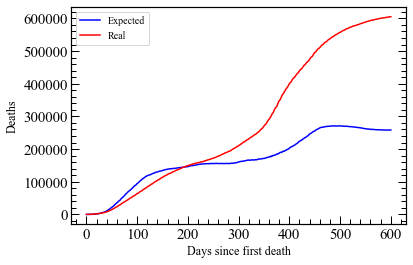

In [20]:
OBM = np.array(covid['deaths_per_100k_inhabitants'][(covid['state'] == 'TOTAL')])*10
OBM = OBM[OBM>0]

fig = plt.subplots(figsize=[6, 4])
plt.plot(EXC[5:-1]*211,'b-',label='Expected')
plt.plot(OBM[9:-1]*211,'r-',label='Real')
plt.xlabel('Days since first death',{'fontsize':12})
plt.ylabel('Deaths',{'fontsize':12})
plt.legend()
sm_ted2()

In [21]:
#Set the timeline in calendar format
inicio = np.array(covid['date'][covid['state'] == 'AC'])[9]
fim = np.array(covid['date'][covid['state'] == 'AC'])[-1]
TEMPO = np.arange(np.datetime64(inicio), np.datetime64(fim))

# Paper Figure 2

## Pearson Correlation Coefficient

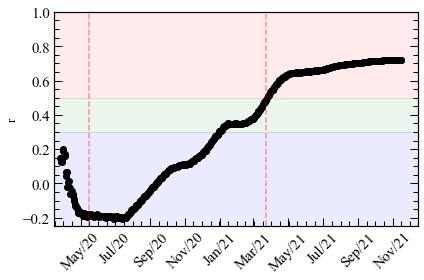

In [22]:
import matplotlib.dates as mdates

limx1 = np.datetime64('2020-03-15')
limx2 = np.datetime64('2021-12-15')

fig = plt.subplots(figsize=[6, 4])
ax1 = plt.subplot(111)
plt.axhspan(ymin=0.5,ymax=1,color='red',alpha=0.08)
plt.axhspan(ymin=0.3,ymax=0.499,color='green',alpha=0.08)
plt.axhspan(ymin=-0.299,ymax=0.299,color='blue',alpha=0.08)
plt.axhspan(ymin=-0.3,ymax=-0.499,color='green',alpha=0.05)
plt.plot(TEMPO, pearson[5:-1],'ko')
plt.axvline(x=np.datetime64('2020-05-16'),color='r',linestyle='--',alpha=0.4)
plt.axvline(x=np.datetime64('2021-03-24'),color='r',linestyle='--',alpha=0.4)
#plt.xlabel('Days since first death',{'fontsize':12})
plt.ylabel('r',{'fontsize':12})
plt.xlim(limx1,limx2)
plt.ylim(-0.25,1)
plt.xticks(rotation=45)

myFmt = mdates.DateFormatter('%b/%y')
ax1.xaxis.set_major_formatter(myFmt)


sm_ted2()

plt.tight_layout()
plt.savefig('FIGURES/FIGURE2.png',dpi=350)

# Paper Figure 3

## Estimation for the excess in total fatality in Brazil due to political influence

602 602


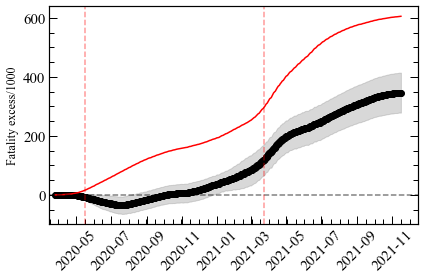

In [23]:
OBM = np.array(covid['deaths_per_100k_inhabitants'][(covid['state'] == 'TOTAL')])*10
OBM = OBM[OBM>0]



excesso = (OBM[9:]*211)-(EXC[5:]*211)
excessoup = (OBM[9:]*211)-((EXC[5:]-EXCerr[5:])*211)
excessodown = (OBM[9:]*211)-((EXC[5:]+EXCerr[5:])*211)

fig = plt.subplots(figsize=[6, 4])
#plt.plot(excessoup/1000)
#plt.plot(excessodown/1000)
plt.fill_between(x=TEMPO, y1=excessodown[:-1]/1000,y2=excessoup[:-1]/1000,color='gray',alpha=0.3)
plt.plot(TEMPO,excesso[:-1]/1000,"ko")
plt.plot(TEMPO,OBM[9:-1]*211/1000,'r-',label='Real')
plt.axhline(y=0,color='k',linestyle='--',alpha=0.5)
plt.axvline(x=np.datetime64('2020-05-16'),color='r',linestyle='--',alpha=0.4)
plt.axvline(x=np.datetime64('2021-03-24'),color='r',linestyle='--',alpha=0.4)
#plt.xlabel('Days since first death',{'fontsize':12})
plt.ylabel('r',{'fontsize':12})
plt.xlim(limx1,limx2)
plt.xticks(rotation=45)

myFmt = mdates.DateFormatter('%b/%y')
ax1.xaxis.set_major_formatter(myFmt)
#plt.xlabel('Days since first death',{'fontsize':12})
plt.ylabel('Fatality excess/1000',{'fontsize':12})

sm_ted2()
plt.tight_layout()
plt.savefig('FIGURES/FIGURE3.png',dpi=350)
print(len(EXC[5:]),len(OBM[9:]))

602 602


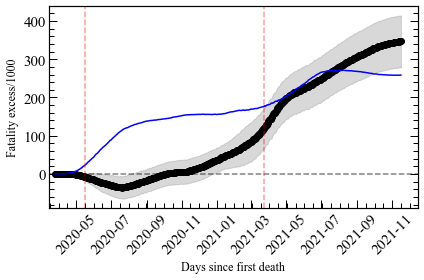

In [24]:
OBM = np.array(covid['deaths_per_100k_inhabitants'][(covid['state'] == 'TOTAL')])*10
OBM = OBM[OBM>0]



excesso = (OBM[9:]*211)-(EXC[5:]*211)
excessoup = (OBM[9:]*211)-((EXC[5:]-EXCerr[5:])*211)
excessodown = (OBM[9:]*211)-((EXC[5:]+EXCerr[5:])*211)

fig = plt.subplots(figsize=[6, 4])
#plt.plot(excessoup/1000)
#plt.plot(excessodown/1000)
plt.fill_between(x=TEMPO, y1=excessodown[:-1]/1000,y2=excessoup[:-1]/1000,color='gray',alpha=0.3)
plt.plot(TEMPO,excesso[:-1]/1000,"ko")
plt.plot(TEMPO,EXC[5:-1]*211/1000,'b-',label='Expected')
plt.axhline(y=0,color='k',linestyle='--',alpha=0.5)
plt.axvline(x=np.datetime64('2020-05-16'),color='r',linestyle='--',alpha=0.4)
plt.axvline(x=np.datetime64('2021-03-24'),color='r',linestyle='--',alpha=0.4)
#plt.xlabel('Days since first death',{'fontsize':12})
plt.ylabel('r',{'fontsize':12})
plt.xlim(limx1,limx2)
plt.xticks(rotation=45)

myFmt = mdates.DateFormatter('%b/%y')
ax1.xaxis.set_major_formatter(myFmt)
plt.xlabel('Days since first death',{'fontsize':12})
plt.ylabel('Fatality excess/1000',{'fontsize':12})

sm_ted2()
plt.tight_layout()
plt.savefig('FIGURES/FIGURE3_2.png',dpi=350)
print(len(EXC[5:]),len(OBM[9:]))

In [50]:
print('Deaths until Nov 17 2021: ', int((OBM[9:]*211)[-1]))
print('Excess of fatality in Nov 17 2021: ',int(excesso[-1]),'+-',int(EXCerr[-1]*211))
print('Excess of fatality in percentage: ', np.round(100*int(excesso[-1])/int((OBM[9:]*211)[-1]),2),'+-',(np.round(100*int(EXCerr[-1]*211)/int((OBM[9:]*211)[-1]),2)))


Deaths until Nov 17 2021:  605477
Excess of fatality in Nov 17 2021:  346909 +- 67701
Excess of fatality in percentage:  57.3 +- 11.18
